# Student Graduation Prediction

In this notebook we will look at creating a good model based on the baseline model in the baseline notebook.

In [2]:
import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance

from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import shap

In [3]:
df = pd.read_csv('data/data.csv',sep=";")

le = LabelEncoder()
y = le.fit_transform(df['Target'])
class_names = list(le.classes_)
X = df.drop(columns=['Target'])


### Feature Engineering
Feature engineering is especially important in this dataset as there are many features which in themselves doesn't mean much, but when combined provides more value.

In [4]:
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        # ratios
        X["approval_ratio_1st"] = X["Curricular units 1st sem (approved)"] / X["Curricular units 1st sem (enrolled)"].replace(0, np.nan)
        X["approval_ratio_2nd"] = X["Curricular units 2nd sem (approved)"] / X["Curricular units 2nd sem (enrolled)"].replace(0, np.nan)
        # avg grade across semesters (ignore zeros)
        X["avg_grade"] = X[["Curricular units 1st sem (grade)", "Curricular units 2nd sem (grade)"]].replace(0, np.nan).mean(axis=1)
        # totals & overall ratio
        X["total_approved"] = X["Curricular units 1st sem (approved)"] + X["Curricular units 2nd sem (approved)"]
        X["total_enrolled"] = X["Curricular units 1st sem (enrolled)"] + X["Curricular units 2nd sem (enrolled)"]
        X["total_approval_ratio"] = X["total_approved"] / X["total_enrolled"].replace(0, np.nan)
        return X.fillna(0.0)

X = X.fillna(0)

### Preprocessing
The dataset has already been cleaned by the dataset authors, so no preprocessing in the form of checking missing values etc. is needed.

Though preprocessing in the form of scaling and encoding categorical values is not needed when it comes to gradient boosting models, and especially not in this dataset when it's already been done by the authors. It could be informative to test whether doing this preprocessing could help give better results.

In [5]:
categorical_cols = [
    "Application mode", "Application order", "Course",
    "Previous qualification", "Nationality", "Mother's qualification",
    "Father's qualification", "Mother's occupation", "Father's occupation",
    "Displaced", "Debtor", "Tuition fees up to date", "Scholarship holder",
    "Gender", "International", "Marital status", "Daytime/evening attendance\t",
    "Educational special needs"
]
categorical_cols = [c for c in categorical_cols if c in X.columns]
numeric_cols = [c for c in X.columns if c not in categorical_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ],
    remainder="drop",
    sparse_threshold=0.3,
)

### Training a Model
We will be using different gradient boosting models like XGBoost, LightGBM and CatBoost for this. In addition, some of the pipelines beneath uses SMOTE, and some don't, this is simply because some did better (in the form of accuracy) with, and some without.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [6]:
classes = np.unique(y_train)
class_counts = np.bincount(y_train)
class_weights = (class_counts.sum() / (len(classes) * class_counts))
sample_weight = class_weights[y_train]

xgb = XGBClassifier(
    n_estimators=400,
    learning_rate=0.08,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    objective="multi:softprob",
    num_class=len(classes),
    eval_metric="mlogloss",
    random_state=42,
    n_jobs=-1,
)

pipe_xgb = ImbPipeline([
    ("fe", FeatureEngineer()),
    # ("pre", preprocess),
    ("clf", xgb),
])

pipe_xgb.fit(X_train, y_train)
y_pred = pipe_xgb.predict(X_test)

print("=== XGBoost ===")
print("Accuracy:", f"{accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred, target_names=class_names))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

=== XGBoost ===
Accuracy: 0.7808
              precision    recall  f1-score   support

     Dropout       0.81      0.76      0.79       284
    Enrolled       0.55      0.48      0.52       159
    Graduate       0.83      0.90      0.86       442

    accuracy                           0.78       885
   macro avg       0.73      0.72      0.72       885
weighted avg       0.77      0.78      0.78       885

Confusion matrix:
 [[217  31  36]
 [ 36  77  46]
 [ 14  31 397]]


In [11]:
pipe_xgb = ImbPipeline(steps=[
    ("fe", FeatureEngineer()),
    # ("pre", preprocess),
    ("smote", SMOTE(random_state=42)),
    ("clf", xgb),
])

pipe_xgb.fit(X_train, y_train)
y_pred_sm = pipe_xgb.predict(X_test)

print("\n=== XGBoost + SMOTE ===")
print("Accuracy:", f"{accuracy_score(y_test, y_pred_sm):.4f}")
print(classification_report(y_test, y_pred_sm, target_names=class_names))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_sm))


=== XGBoost + SMOTE ===
Accuracy: 0.7672
              precision    recall  f1-score   support

     Dropout       0.80      0.74      0.77       284
    Enrolled       0.51      0.50      0.50       159
    Graduate       0.83      0.88      0.86       442

    accuracy                           0.77       885
   macro avg       0.71      0.71      0.71       885
weighted avg       0.76      0.77      0.77       885

Confusion matrix:
 [[210  39  35]
 [ 37  79  43]
 [ 15  37 390]]


In [8]:
catboost_clf = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    loss_function="MultiClass",
    random_state=42,
    verbose=False,
)

pipe_catboost_smote = ImbPipeline([
    ("fe", FeatureEngineer()),
    ("clf", catboost_clf),
])

pipe_catboost_smote.fit(X_train, y_train)
y_pred_cat = pipe_catboost_smote.predict(X_test)

print("\n=== CatBoost ===")
print("Accuracy:", f"{accuracy_score(y_test, y_pred_cat):.4f}")
print(classification_report(y_test, y_pred_cat, target_names=class_names))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_cat))


=== CatBoost ===
Accuracy: 0.7819
              precision    recall  f1-score   support

     Dropout       0.80      0.77      0.79       284
    Enrolled       0.57      0.43      0.49       159
    Graduate       0.82      0.92      0.87       442

    accuracy                           0.78       885
   macro avg       0.73      0.71      0.72       885
weighted avg       0.77      0.78      0.77       885

Confusion matrix:
 [[218  26  40]
 [ 41  69  49]
 [ 12  25 405]]


In [9]:
lgbm_clf = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=63,
    objective="multiclass",
    random_state=42,
    verbose=-1,
)

pipe_lgbm = ImbPipeline([
    ("fe", FeatureEngineer()),
    ("clf", lgbm_clf),
])

pipe_lgbm.fit(X_train, y_train)
y_pred_lgbm = pipe_lgbm.predict(X_test)

print("\n=== LightGBM ===")
print("Accuracy:", f"{accuracy_score(y_test, y_pred_lgbm):.4f}")
print(classification_report(y_test, y_pred_lgbm, target_names=class_names))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_lgbm))


=== LightGBM ===
Accuracy: 0.7763
              precision    recall  f1-score   support

     Dropout       0.82      0.76      0.79       284
    Enrolled       0.54      0.47      0.51       159
    Graduate       0.82      0.89      0.85       442

    accuracy                           0.78       885
   macro avg       0.73      0.71      0.72       885
weighted avg       0.77      0.78      0.77       885

Confusion matrix:
 [[217  30  37]
 [ 33  75  51]
 [ 14  33 395]]


Multiclass ROC-AUC (OVR): 0.8961


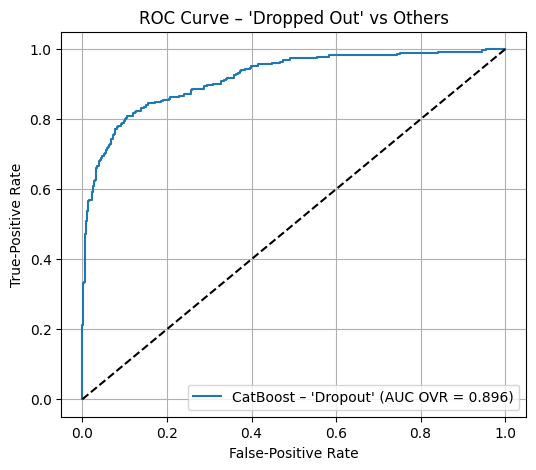

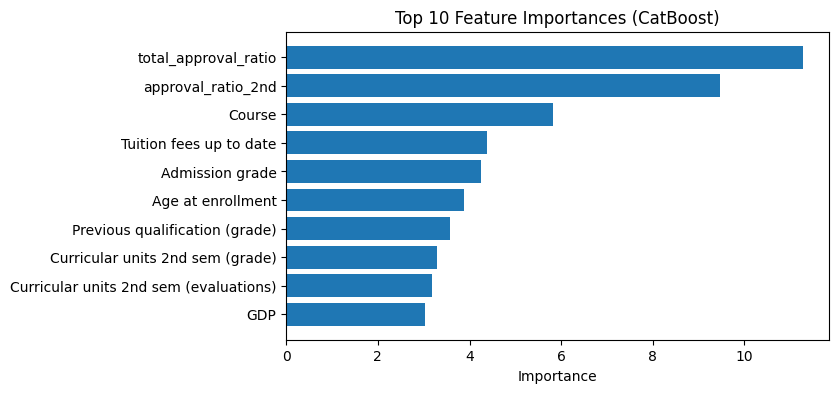

In [17]:
from sklearn.metrics import roc_auc_score, roc_curve

# --- Probabilities for each class (CatBoost, multiclass) ---
proba_cat = pipe_catboost_smote.predict_proba(X_test)

# --- Multiclass ROC-AUC (OVR) ---
roc_auc_cat = roc_auc_score(y_test, proba_cat, multi_class="ovr")
print(f"Multiclass ROC-AUC (OVR): {roc_auc_cat:.4f}")

# --- ROC curve for the 'Dropout' class ---
dropped_label = "Dropout"
dropped_idx = class_names.index(dropped_label)   # class_names from your LabelEncoder
y_true_dropped = (y_test == dropped_idx).astype(int)
y_score_dropped = proba_cat[:, dropped_idx]

fpr_cat, tpr_cat, _ = roc_curve(y_true_dropped, y_score_dropped)
plt.figure(figsize=(6, 5))
plt.plot(fpr_cat, tpr_cat, label=f"CatBoost – '{dropped_label}' (AUC OVR = {roc_auc_cat:.3f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False-Positive Rate")
plt.ylabel("True-Positive Rate")
plt.title("ROC Curve – 'Dropped Out' vs Others")
plt.legend()
plt.grid(True)
plt.show()

# --- Top-10 feature importances (deterministic feature names) ---
clf = pipe_catboost_smote.named_steps["clf"]
importances = clf.get_feature_importance()

# Derive feature names from the FE step applied to training data
fe_step = pipe_catboost_smote.named_steps["fe"]
fe_X_train = fe_step.transform(X_train)          # X_train is a DataFrame in your setup
feature_names = list(fe_X_train.columns)         # matches importances length

importance_df = (
    pd.DataFrame({"Feature": feature_names, "Importance": importances})
    .sort_values("Importance", ascending=False)
    .head(10)
)

plt.figure(figsize=(7, 4))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.gca().invert_yaxis()
plt.title("Top 10 Feature Importances (CatBoost)")
plt.xlabel("Importance")
plt.show()